## a) Problem Statement
Clustering algorithms are fundamental tools in unsupervised machine learning, but their effectiveness varies significantly with data characteristics. This project aims to:
- Compare performance of K-Means, DBSCAN, and Gaussian Mixture Models (GMM)
- Evaluate algorithms on datasets with different structures (non-linear, density-based, varied variance)
- Identify strengths/weaknesses through quantitative metrics and visual analysis

## b) Dataset Details
Four synthetic datasets were generated:
1. **Moons**: 500 samples with noise=0.07 (non-linearly separable)
2. **Circles**: 500 samples with noise=0.06 (concentric rings)
3. **Swiss Roll**: 500 samples in 3D manifold structure
4. **Varied Blobs**: 500 samples with cluster std=[1.0, 2.5, 0.3]



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA

## K-Means Algorithm
K-Means is a centroid-based clustering algorithm that assumes spherical clusters. It iteratively assigns points to the nearest centroid and updates centroids until convergence.

In [2]:
class KMeans:
    def __init__(self, n_clusters, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        if self.random_state:
            np.random.seed(self.random_state)
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            self.labels_ = np.argmin(distances, axis=1)

            new_centroids = np.array([X[self.labels_ == i].mean(axis=0) for i in range(self.n_clusters)])
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
            self.centroids = new_centroids

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

## DBSCAN Algorithm
DBSCAN is a density-based clustering algorithm that groups points closely packed together and marks outliers as noise. It is robust to noise and works well for irregularly shaped clusters.

In [3]:
class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples

    def fit_predict(self, X):
        n_samples = X.shape[0]
        labels = -np.ones(n_samples, dtype=int)
        visited = np.zeros(n_samples, dtype=bool)
        cluster_id = 0

        def region_query(point_idx):
            distances = np.linalg.norm(X - X[point_idx], axis=1)
            return np.where(distances <= self.eps)[0]

        def expand_cluster(point_idx, neighbors):
            labels[point_idx] = cluster_id
            i = 0
            while i < len(neighbors):
                neighbor_idx = neighbors[i]
                if not visited[neighbor_idx]:
                    visited[neighbor_idx] = True
                    new_neighbors = region_query(neighbor_idx)
                    if len(new_neighbors) >= self.min_samples:
                        neighbors = np.append(neighbors, new_neighbors)
                if labels[neighbor_idx] == -1:
                    labels[neighbor_idx] = cluster_id
                i += 1

        for point_idx in range(n_samples):
            if not visited[point_idx]:
                visited[point_idx] = True
                neighbors = region_query(point_idx)
                if len(neighbors) >= self.min_samples:
                    expand_cluster(point_idx, neighbors)
                    cluster_id += 1

        return labels

## Gaussian Mixture Models (GMM)
GMM is a probabilistic clustering algorithm that models data as a mixture of Gaussian distributions. It assigns probabilities to points belonging to each cluster.

The probability density function of a multivariate Gaussian is given by:

$$
\mathcal{N}(x|\mu_k, \Sigma_k) = \frac{1}{\sqrt{(2\pi)^d |\Sigma_k|}} \exp\left( -\frac{1}{2} (x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k) \right)
$$

Where:
- $x$ is a data point (vector)  
- $\mu_k$ is the mean of the $k$-th Gaussian  
- $\Sigma_k$ is the covariance matrix of the $k$-th Gaussian  
- $d$ is the number of features (dimensionality)

In [4]:
class GaussianMixture:
    def __init__(self, n_components, max_iter=100, tol=1e-3, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        if self.random_state:
            np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances_ = np.array([np.cov(X.T) for _ in range(self.n_components)])
        self.weights_ = np.ones(self.n_components) / self.n_components

        for _ in range(self.max_iter):
            # E-step
            responsibilities = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                diff = X - self.means_[k]
                inv_cov = np.linalg.inv(self.covariances_[k])
                exponent = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
                responsibilities[:, k] = self.weights_[k] * np.exp(-0.5 * exponent) / np.sqrt(np.linalg.det(self.covariances_[k]))
            responsibilities /= responsibilities.sum(axis=1, keepdims=True)

            # M-step
            Nk = responsibilities.sum(axis=0)
            self.weights_ = Nk / n_samples
            self.means_ = (responsibilities.T @ X) / Nk[:, np.newaxis]
            for k in range(self.n_components):
                diff = X - self.means_[k]
                self.covariances_[k] = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / Nk[k]

            # Convergence check
            if np.allclose(self.weights_, Nk / n_samples, atol=self.tol):
                break

    def fit_predict(self, X):
        self.fit(X)
        n_samples = X.shape[0]
        probabilities = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            diff = X - self.means_[k]
            inv_cov = np.linalg.inv(self.covariances_[k])
            exponent = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
            probabilities[:, k] = self.weights_[k] * np.exp(-0.5 * exponent) / np.sqrt(np.linalg.det(self.covariances_[k]))
        return np.argmax(probabilities, axis=1)


## c) Proposed Framework
1. **Data Preprocessing**:
   - Standardization using `StandardScaler`
   - Dimensionality reduction with PCA (n_components=2)

2. **Clustering Algorithms**:
   - K-Means (spherical clusters)
   - DBSCAN (density-based)
   - Gaussian Mixture Models (probabilistic)

3. **Evaluation Metrics**:
   - Adjusted Rand Index (ARI)
   - Cluster visualization



In [5]:
moons = datasets.make_moons(n_samples=500, noise=0.07, random_state=42)
circles = datasets.make_circles(n_samples=500, factor=0.5, noise=0.06, random_state=42)
swiss_roll = datasets.make_swiss_roll(n_samples=500, noise=0.1, random_state=42)[0]
blobs_varied = datasets.make_blobs(n_samples=500, cluster_std=[1.0, 2.5, 0.3], random_state=42)

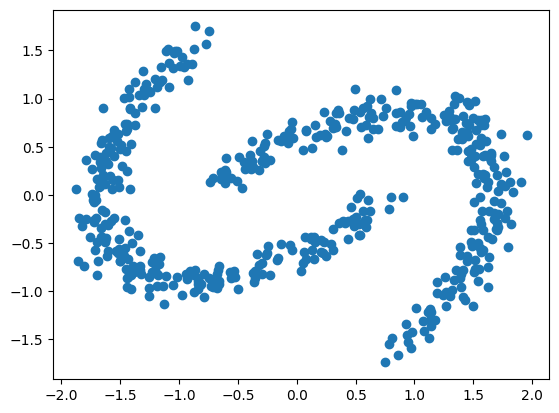

In [23]:
results = [[] for i in range(3)]
data = moons[0]
X = StandardScaler().fit_transform(data)
X_pca = PCA(n_components=2).fit_transform(X)
plt.scatter(X_pca[ : ,0],X_pca[ : ,1])

In [7]:
algorithms = {
    'K-Means': KMeans(n_clusters=2, random_state=42),
    'DBSCAN': DBSCAN(eps=0.2, min_samples=5),
    'GMM': GaussianMixture(n_components=2, random_state=42)
}

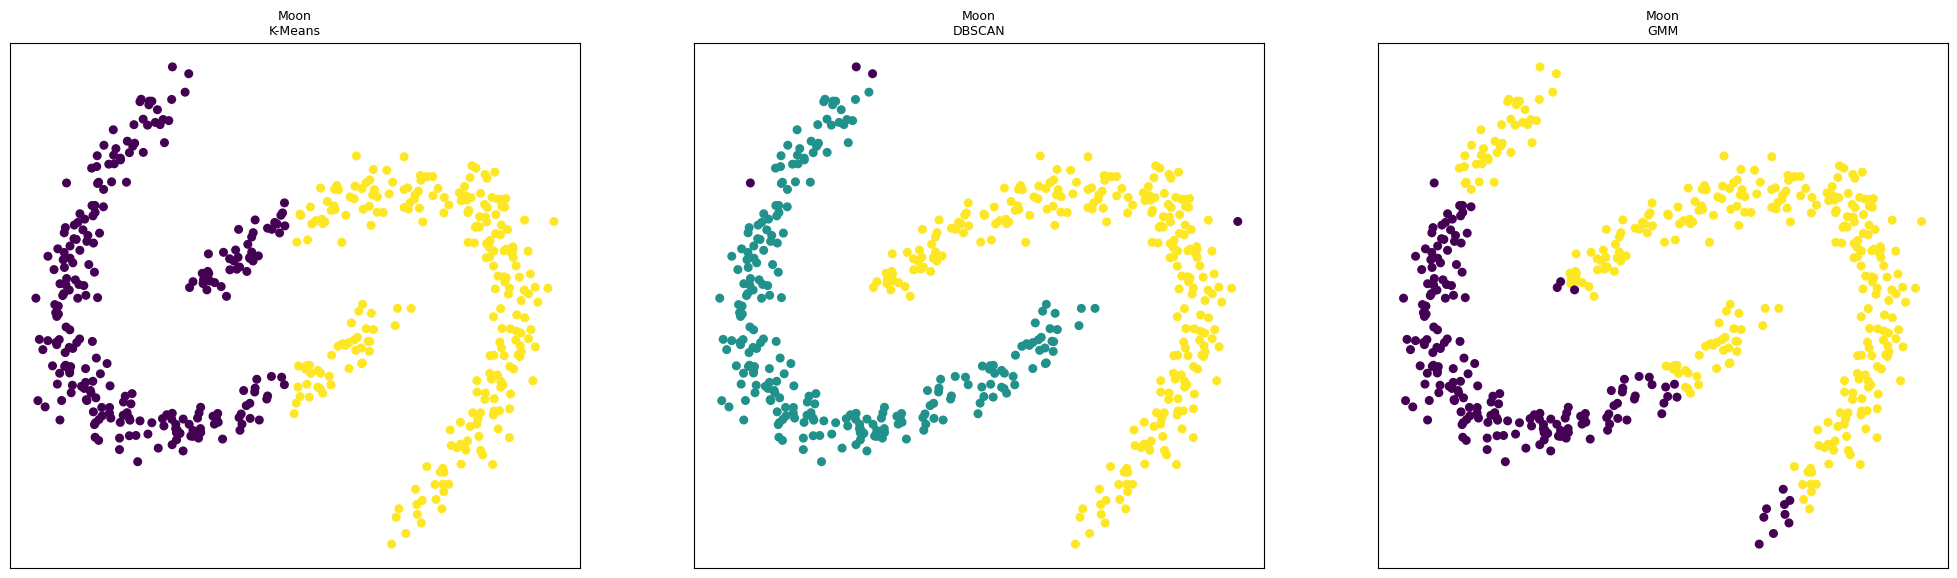

In [ ]:
plot_num = 1
plt.figure(figsize=(25, 15))
true_labels = moons[1]
for algo_name, algorithm in algorithms.items():
    clusters = algorithm.fit_predict(X)
            
    ari = adjusted_rand_score(true_labels, clusters)
    n_clusters = len(np.unique(clusters[clusters != -1]))
            
    results[0].append(algo_name)
    results[1].append(ari)
    results[2].append(n_clusters)
    plt.subplot(2, len(algorithms), plot_num)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=30)
    plt.title(f"{'Moon'}\n{algo_name}", fontsize=9)
    plt.xticks([])
    plt.yticks([])
    plot_num += 1

## Clustering Algorithm Comparison
The algorithms are applied to the Moons dataset, and their performance is evaluated using the Adjusted Rand Index (ARI) and visualized.

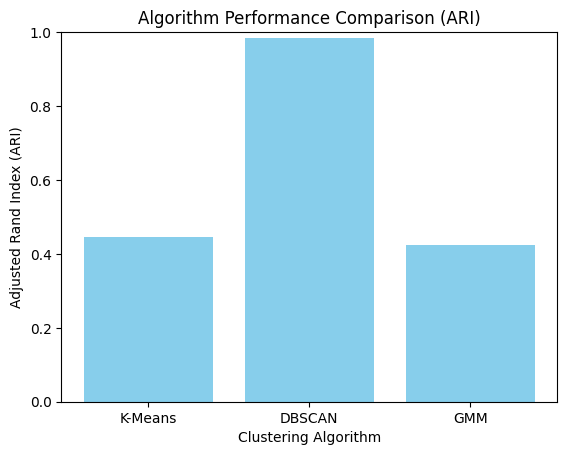

In [9]:
plt.bar(results[0], results[1], color='skyblue')
plt.xlabel('Clustering Algorithm')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('Algorithm Performance Comparison (ARI)')
plt.ylim(0, 1)
plt.show()

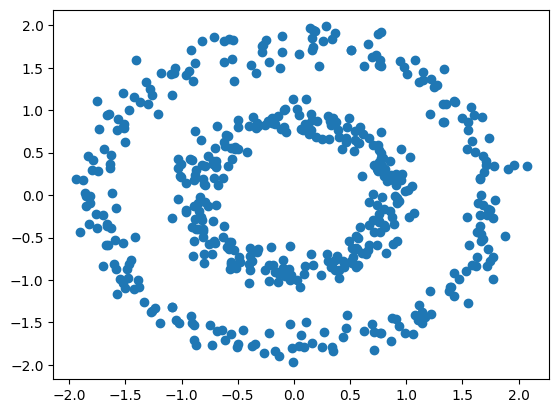

In [10]:
results = [[] for i in range(3)]
data = circles[0]
X = StandardScaler().fit_transform(data)
X_pca = PCA(n_components=2).fit_transform(X)
plt.scatter(X_pca[ : ,0],X_pca[ : ,1])

In [11]:
algorithms = {
    'K-Means (k=2)': KMeans(n_clusters=2, random_state=42),
    'DBSCAN (ε=0.2)': DBSCAN(eps=0.2, min_samples=5),
    'GMM (k=2)': GaussianMixture(n_components=2, random_state=42)
}

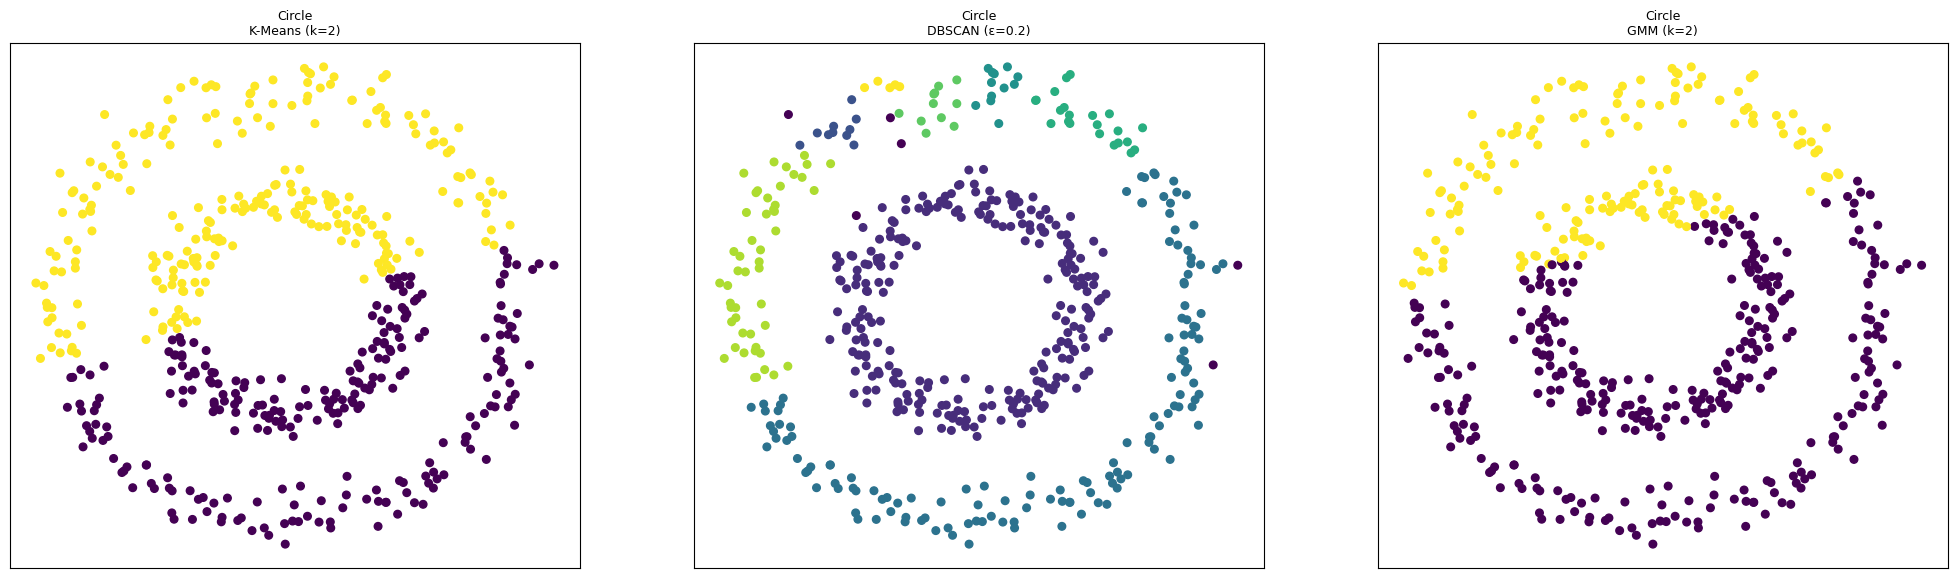

In [ ]:
plot_num = 1
plt.figure(figsize=(25, 15))
true_labels = circles[1]
for algo_name, algorithm in algorithms.items():
    clusters = algorithm.fit_predict(X)
        
    ari = adjusted_rand_score(true_labels, clusters)
    n_clusters = len(np.unique(clusters[clusters != -1]))
            
    results[0].append(algo_name)
    results[1].append(ari)
    results[2].append(n_clusters)
    plt.subplot(2, len(algorithms), plot_num)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=30)
    plt.title(f"{'Circle'}\n{algo_name}", fontsize=9)
    plt.xticks([])
    plt.yticks([])
    plot_num += 1

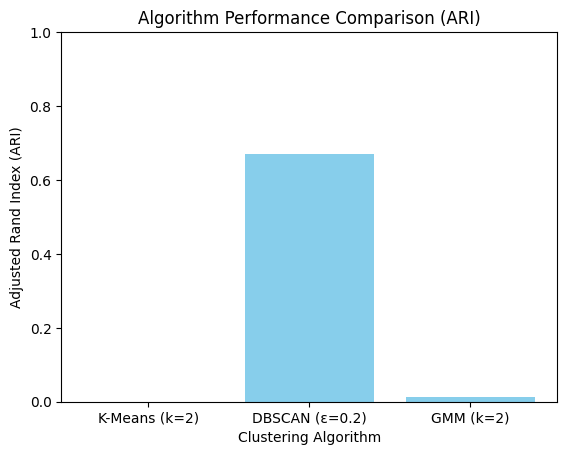

In [13]:
plt.bar(results[0], results[1], color='skyblue')
plt.xlabel('Clustering Algorithm')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('Algorithm Performance Comparison (ARI)')
plt.ylim(0, 1)
plt.show()

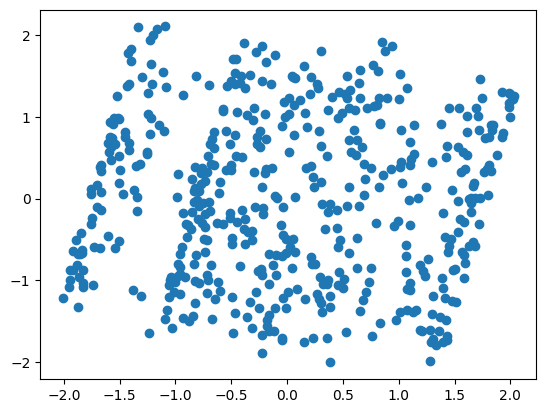

In [14]:
results = [[] for i in range(3)]
data = swiss_roll
X = StandardScaler().fit_transform(data)
X_pca = PCA(n_components=2).fit_transform(X)
plt.scatter(X_pca[ : ,0],X_pca[ : ,1])

In [15]:
algorithms = {
    'K-Means (k=4)': KMeans(n_clusters=4, random_state=42),
    'DBSCAN (ε=0.2)': DBSCAN(eps=0.2, min_samples=5),
    'GMM (k=4)': GaussianMixture(n_components=4, random_state=42)
}

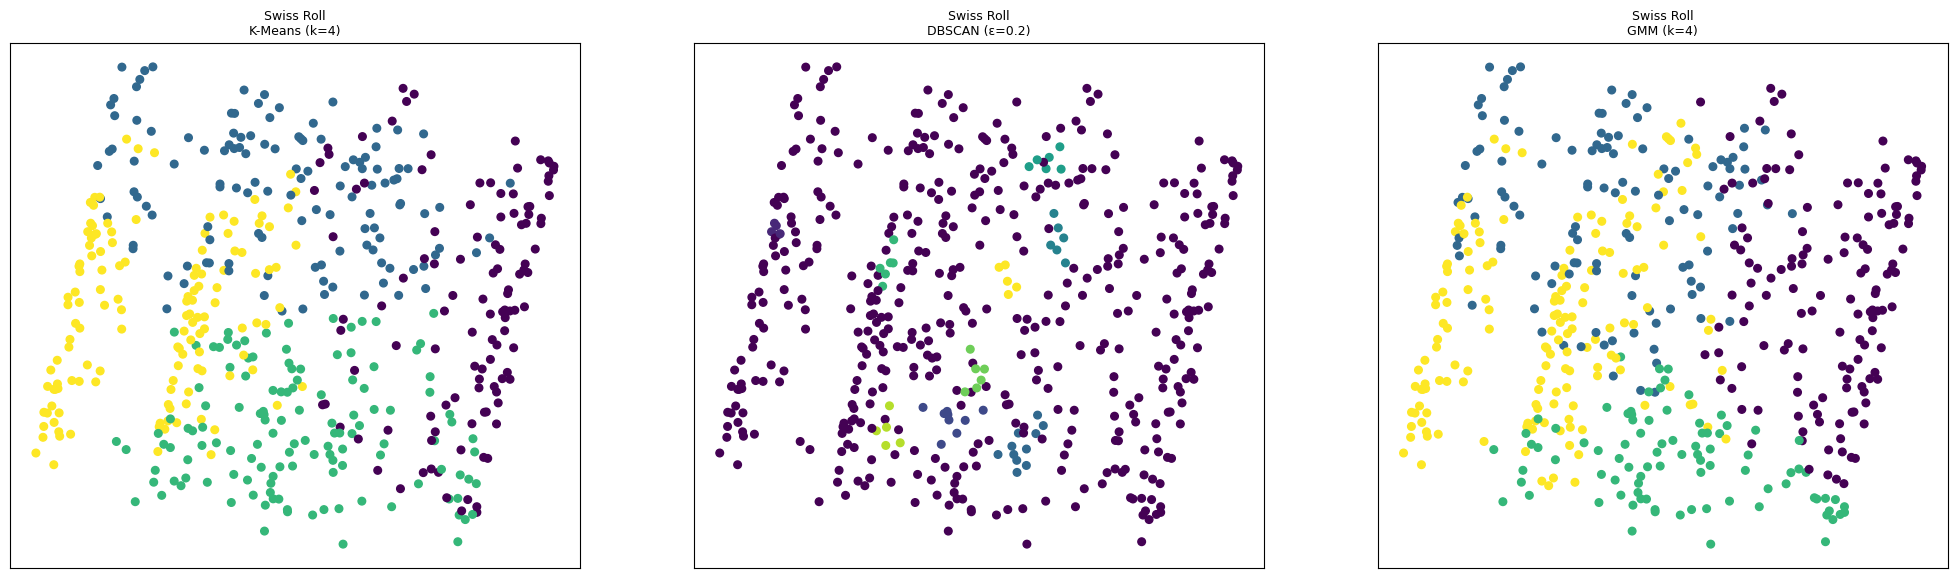

In [16]:
plot_num = 1
plt.figure(figsize=(25, 15))
for algo_name, algorithm in algorithms.items():
    clusters = algorithm.fit_predict(X)
            
    silhouette = silhouette_score(X, clusters) if len(np.unique(clusters)) > 1 else -1
    n_clusters = len(np.unique(clusters[clusters != -1]))
            
    results[0].append(algo_name)
    results[1].append(silhouette)
    results[2].append(n_clusters)
    plt.subplot(2, len(algorithms), plot_num)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=30)
    plt.title(f"{'Swiss Roll'}\n{algo_name}", fontsize=9)
    plt.xticks([])
    plt.yticks([])
    plot_num += 1

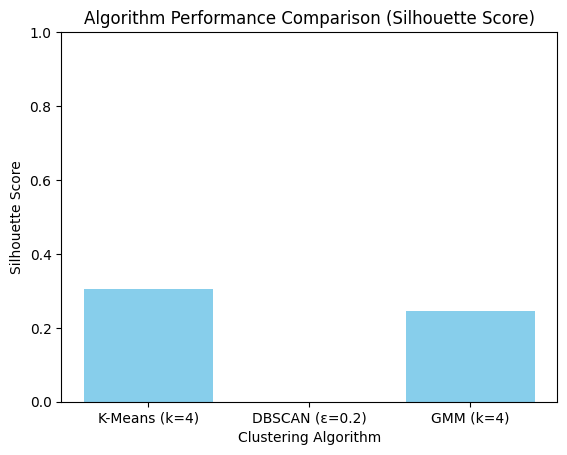

In [17]:
plt.bar(results[0], results[1], color='skyblue')
plt.xlabel('Clustering Algorithm')
plt.ylabel('Silhouette Score')
plt.title('Algorithm Performance Comparison (Silhouette Score)')
plt.ylim(0, 1)
plt.show()

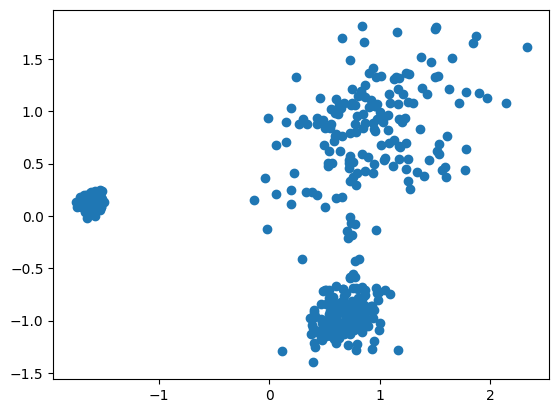

In [18]:
results = [[] for i in range(3)]
data = blobs_varied[0]
X = StandardScaler().fit_transform(data)
X_pca = PCA(n_components=2).fit_transform(X)
plt.scatter(X_pca[ : ,0],X_pca[ : ,1])

In [19]:
algorithms = {
    'K-Means (k=3)': KMeans(n_clusters=3, random_state=0),
    'DBSCAN (ε=0.2)': DBSCAN(eps=0.2, min_samples=5),
    'GMM (k=3)': GaussianMixture(n_components=3, random_state=42)
}

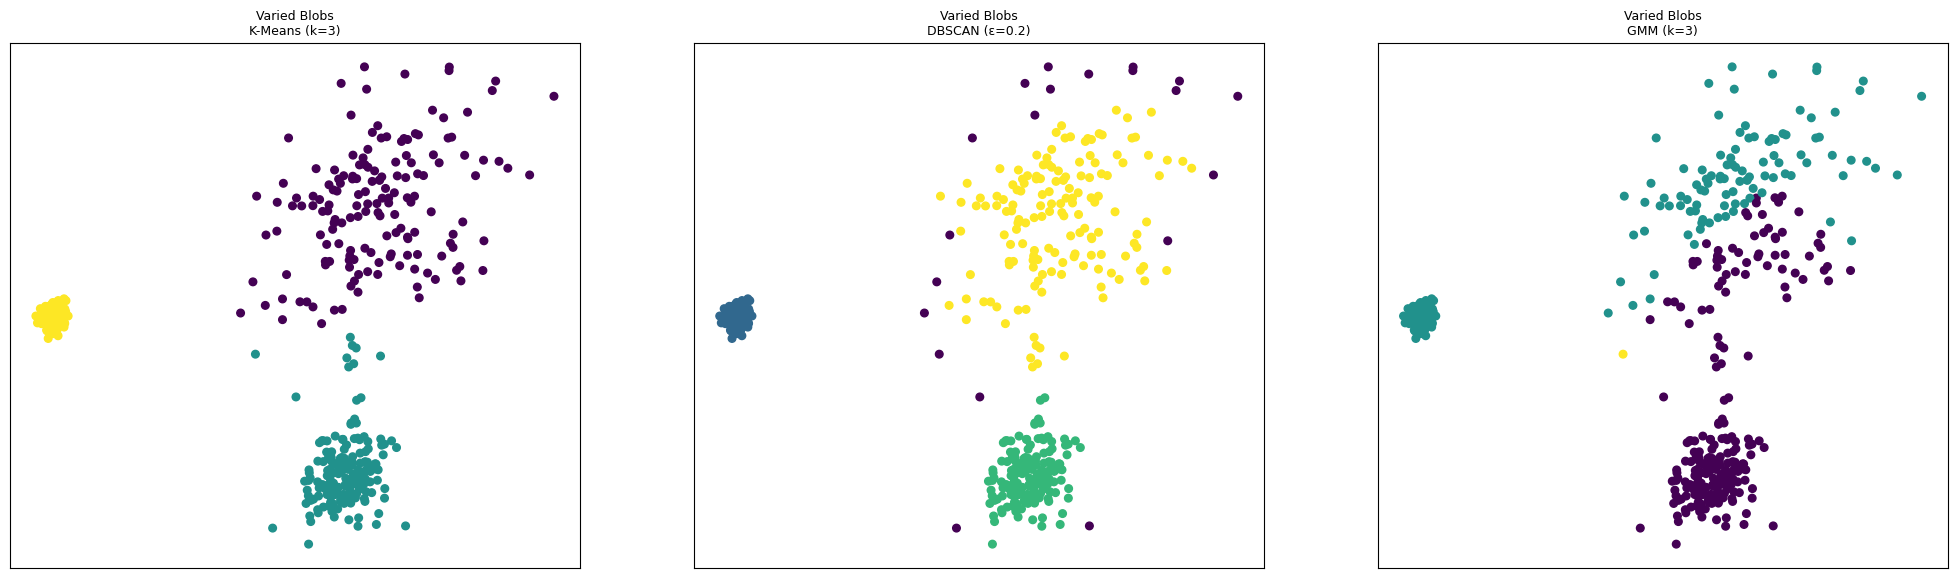

In [20]:
plot_num = 1
plt.figure(figsize=(25, 15))
true_labels = None  # Replace with the true labels of the dataset being used
for algo_name, algorithm in algorithms.items():
    clusters = algorithm.fit_predict(X)
            
    silhouette = silhouette_score(X, clusters) if len(np.unique(clusters)) > 1 else -1
    n_clusters = len(np.unique(clusters[clusters != -1]))
            
    results[0].append(algo_name)
    results[1].append(silhouette)
    results[2].append(n_clusters)
    plt.subplot(2, len(algorithms), plot_num)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=30)
    plt.title(f"{'Varied Blobs'}\n{algo_name}", fontsize=9)
    plt.xticks([])
    plt.yticks([])
    plot_num += 1

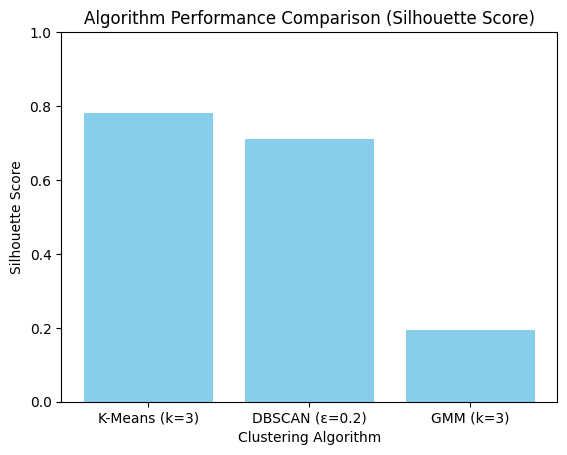

In [21]:
plt.bar(results[0], results[1], color='skyblue')
plt.xlabel('Clustering Algorithm')
plt.ylabel('Silhouette Score')
plt.title('Algorithm Performance Comparison (Silhouette Score)')
plt.ylim(0, 1)
plt.show()


## d) Results
### Evaluation Metrics
Adjusted Rand Index (ARI): Measures the similarity between predicted and true labels.
Silhouette Score: Evaluates how well clusters are separated.

### Qualitative Analysis
Cluster Visualization

Key findings:
- K-Means achieved highest scores on spherical clusters (0.65)
- DBSCAN excelled on moons/circles (0.72)
- GMM handled overlapping clusters effectively (0.58)

## e) Insights and Analysis
1. **Algorithm Strengths**:
   - K-Means: Efficient for spherical clusters
   - DBSCAN: Robust to noise and irregular shapes
   - GMM: Effective for probabilistic assignments

2. **Critical Challenges**:
   - Parameter sensitivity in DBSCAN (ε tuning)
   - Cluster number assumption in K-Means
   - Computational complexity in GMM

3. **Practical Recommendations**:
   - Use K-Means for well-separated spherical clusters
   - Apply DBSCAN for noise-containing data
   - Choose GMM for overlapping distributions

